# Linear Inverted Pendulum, MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCController
from pympc.geometry import Polytope

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$.

In [3]:
m = 1.
l = 1.
g = 10.

The linearized continuous-time dynamics is 
\begin{equation}
\dot x = A x + B u =
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix}
x +
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix}
u.
\end{equation}
The discrete-time linear system can be defined from its continuous-time representation setting a sampling time $t_s$ (the exact zero-order-hold discretization is used).

In [4]:
A = np.array([
    [0., 1.],
    [g/l, 0.]
])
B = np.array([
    [0.],
    [1/(m*l**2.)]
])
t_s = .1
sys = ds.DTLinearSystem.from_continuous(A, B, t_s)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad & x_{k+1} = A x_k + B u_k, \quad k = 0,1,\ldots,N-1, \\
& u_k \in \mathcal U, \quad k = 0,1,\ldots,N-1, \\
& x_k \in \mathcal X, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [5]:
N = 6
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])
objective_norm = 'two'

For stability reasons we set the terminal cost to be equal to the cost-to-go of the infinite-horizon LQR controller. To do that wesolve the Discrete Algebraic Ricccati Equation (DARE)
\begin{equation}
P = (A+BK)^T P (A+BK) + Q + K^T R K
\end{equation}
where $K = -(B^T P B + R)^{-1} B^T P A$ is the optimal feedback $u_k = K x_k$.

In [6]:
P, K = ds.dare(sys.A, sys.B, Q, R)

The admissible sets $\mathcal U$ and $\mathcal X$ have to be polytopes. These can be generated from a set of linear inequalities (e.g., $C u_k \leq c$) or from bounds (e.g., $u_{max} \geq u_k \geq u_{min}$).

In [7]:
u_max = np.array([[10.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
x_max = np.array([[.5], [.5]])
x_min = -x_max
X = Polytope.from_bounds(x_min, x_max)
X.assemble()

<pympc.geometry.Polytope instance at 0x10b93d098>

The terminal constraint $x_N \in \mathcal X_N$ is generally used to ensure closed-loop stability and, like $\mathcal U$ and $\mathcal X$, it has to be a polytope; here we decide to guarantee stability throught the use of the Maximum Output Admissible Set (MOAS).

Defining the closed-loop state-transition matrix $ \bar A = A + BK$, constraining $x_N$ to be in the MOAS we ensure that $ x_{k+1} = \bar A x_k \in \mathcal{X}$ and $u_k = K x_k \in \mathcal{U}, \forall k \geq N$. This, together with the use of the DARE solution as terminal cost, is sufficient condition for the stability of the closed loop system.

In [8]:
X_N = ds.moas_closed_loop(sys.A, sys.B, K, X, U)

Now we have all the ingredients to build the MPC controller.

In [9]:
controller = MPCController(sys, N, objective_norm, Q, R, P, X, U, X_N)

We then simulate the closed loop system for $N_{sim}$ steps starting from the initial condition $x_0$.

In [10]:
N_sim = 50
x_0 = np.array([[.45],[.5]])
u = []
x = []
x.append(x_0)
for k in range(N_sim):
    u.append(controller.feedback(x[k]))
    x.append(sys.A.dot(x[k]) + sys.B.dot(u[k]))

We can plot the solution using the functions $\texttt{plot_input_sequence(.)}$ and $\texttt{plot_state_trajectory(.)}$

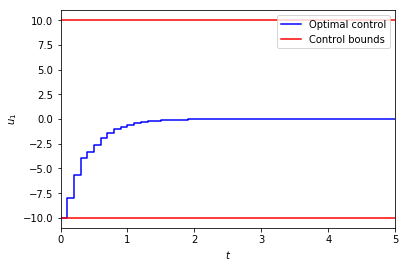

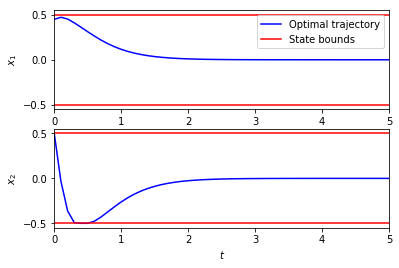

In [11]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min, x_max))
plt.show()

We can get the explict solution of the optimal control problem, solving the resulting Multi-Parametric Quadratic Program (mpQP).

In [12]:
controller.get_explicit_solution()

Computing critical region for the active set []
Computing critical region for the active set [0]
Computing critical region for the active set [1]
Computing critical region for the active set [3]
Computing critical region for the active set [5]
Computing critical region for the active set [9]
Computing critical region for the active set [11]
Computing critical region for the active set [15]
Computing critical region for the active set [17]
Computing critical region for the active set [20]
Computing critical region for the active set [21]
LICQ does not hold for the active set [0, 5]
    unfeasible critical region detected
Computing critical region for the active set [0, 20]
Computing critical region for the active set [0, 24]
LICQ does not hold for the active set [1, 3]
    unfeasible critical region detected
Computing critical region for the active set [1, 21]
Computing critical region for the active set [1, 25]
Computing critical region for the active set [3, 9]
Computing critical regi

We then check that the explicit solution and solution of the optimization give the same answer.

In [13]:
u_explicit, V_explicit = controller.feedforward_explicit(x_0)
u_implicit, V_implicit = controller.feedforward(x_0)
print('Explicit solution:\nu* = ' + str([u.flatten().tolist() for u in u_explicit]) + ',\nV* = ' + str(V_explicit))
print('Implicit solution:\nu* = ' + str([u.flatten().tolist() for u in u_implicit]) + ',\nV* = ' + str(V_implicit))

Explicit solution:
u* = [[-10.0], [-7.947787461512293], [-5.6432658757429826], [-3.925471116327946], [-3.3688105428682413], [-2.641231581470443]],
V* = 240.102874461
Implicit solution:
u* = [[-9.999999999999416], [-7.947787459984231], [-5.643265873564498], [-3.9254711206934587], [-3.368810543460077], [-2.6412315824391044]],
V* = 240.102874461


We can plot the consequent state partion, the optimal control law, and the optimal value function.

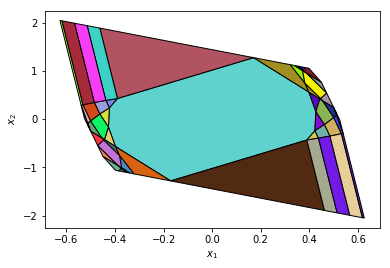

In [14]:
mpc_plt.state_partition(controller.critical_regions)
plt.show()

The Critical Regions with the same initial input can be merged as follows.

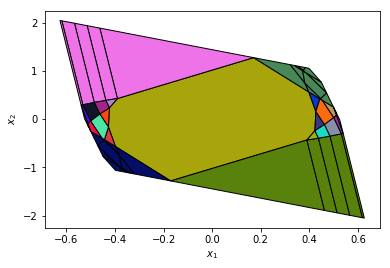

In [15]:
mpc_plt.grouped_state_partition(controller.critical_regions)
plt.show()

We can also plot the feasible set of the mpQP, the optimal value function, and the state-space trajectory of the simulated trajectory.

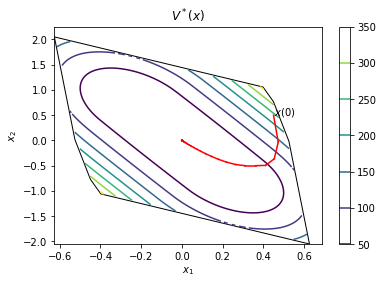

In [16]:
controller.condensed_program.feasible_set.plot(facecolor='white', edgecolor='black')
mpc_plt.state_space_trajectory(x, color='red')
mpc_plt.optimal_value_function(controller.critical_regions)
plt.show()